✅ Archivo enriquecido guardado como 'resumen_simulaciones_pvwatts_metrico.csv'


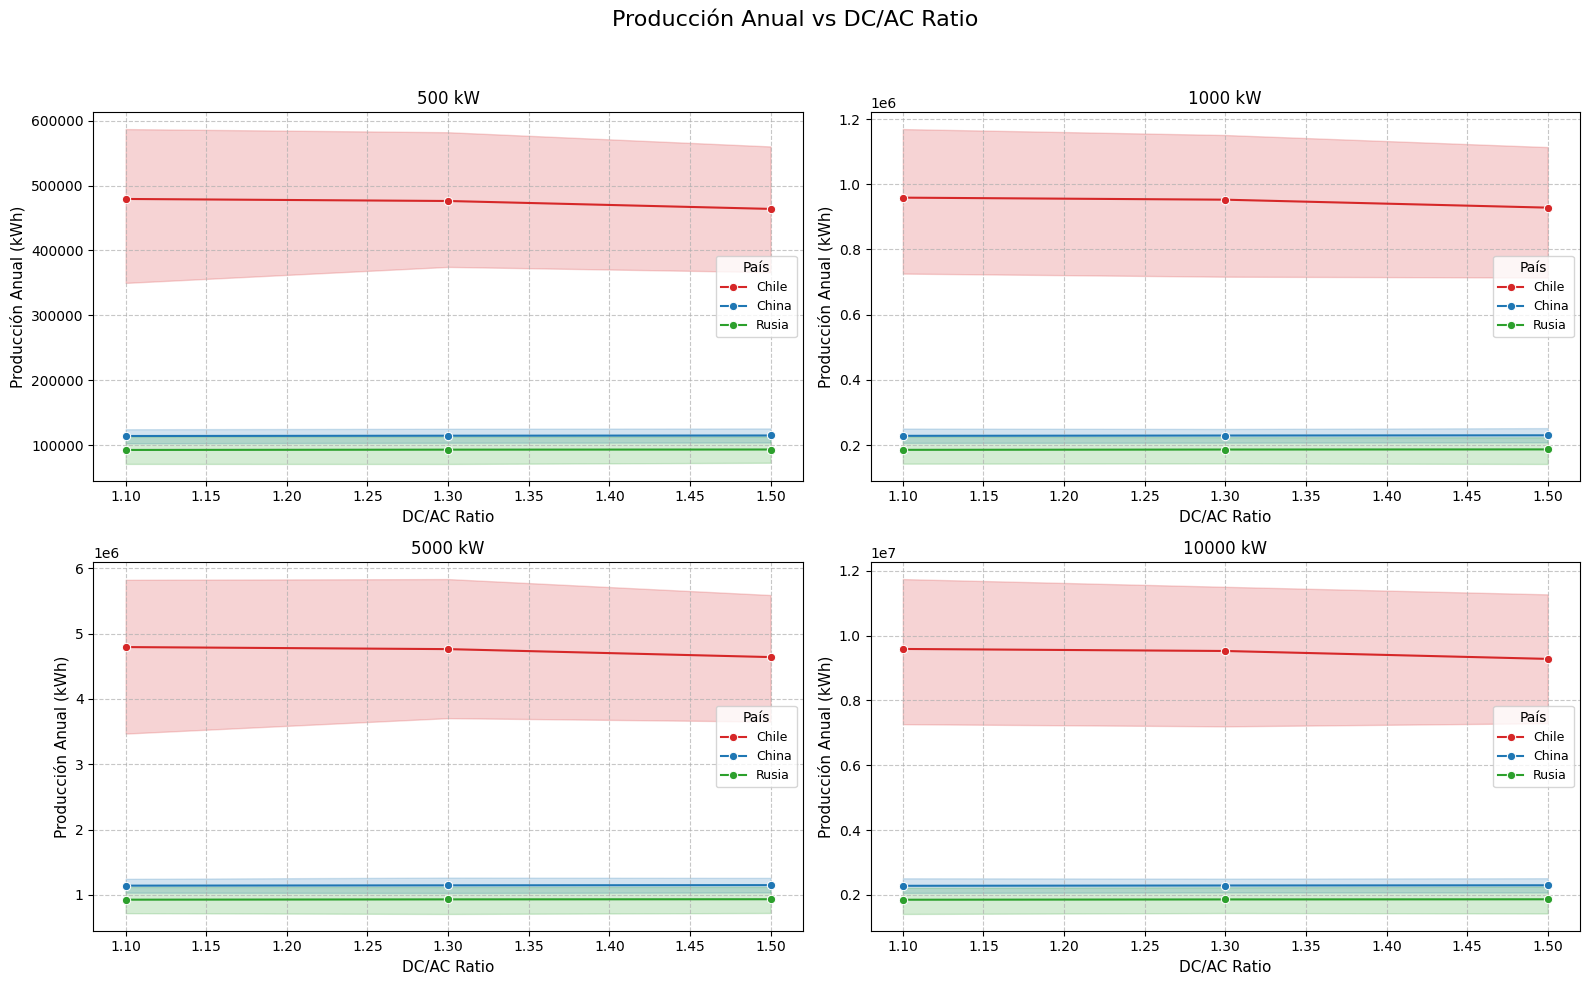

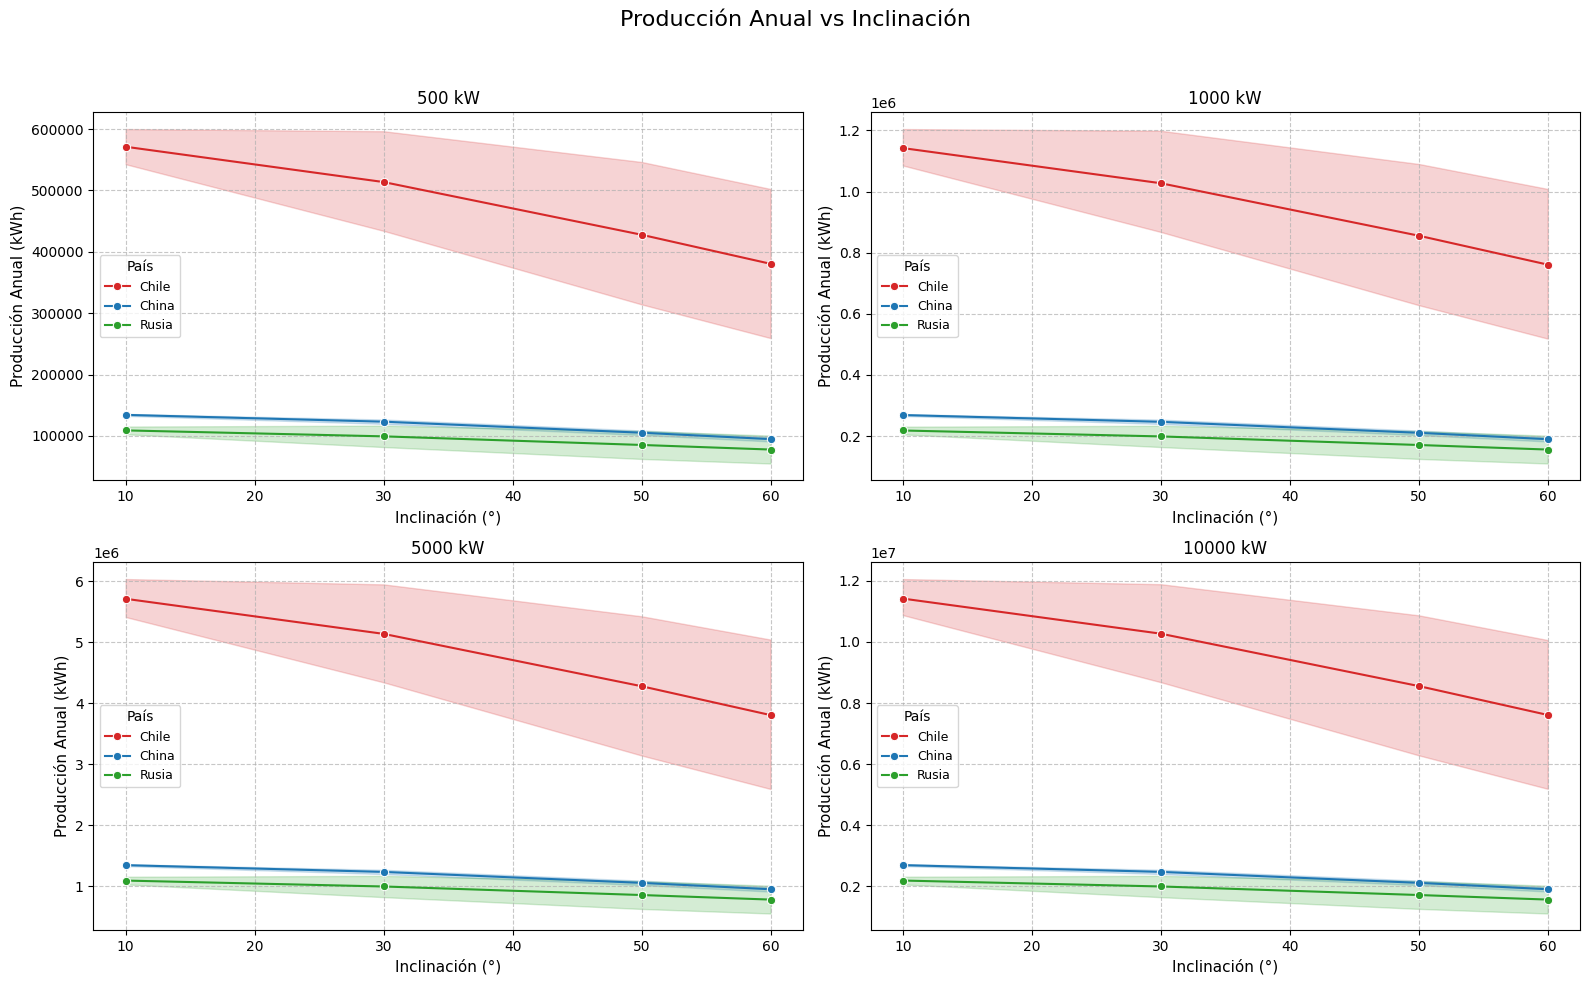

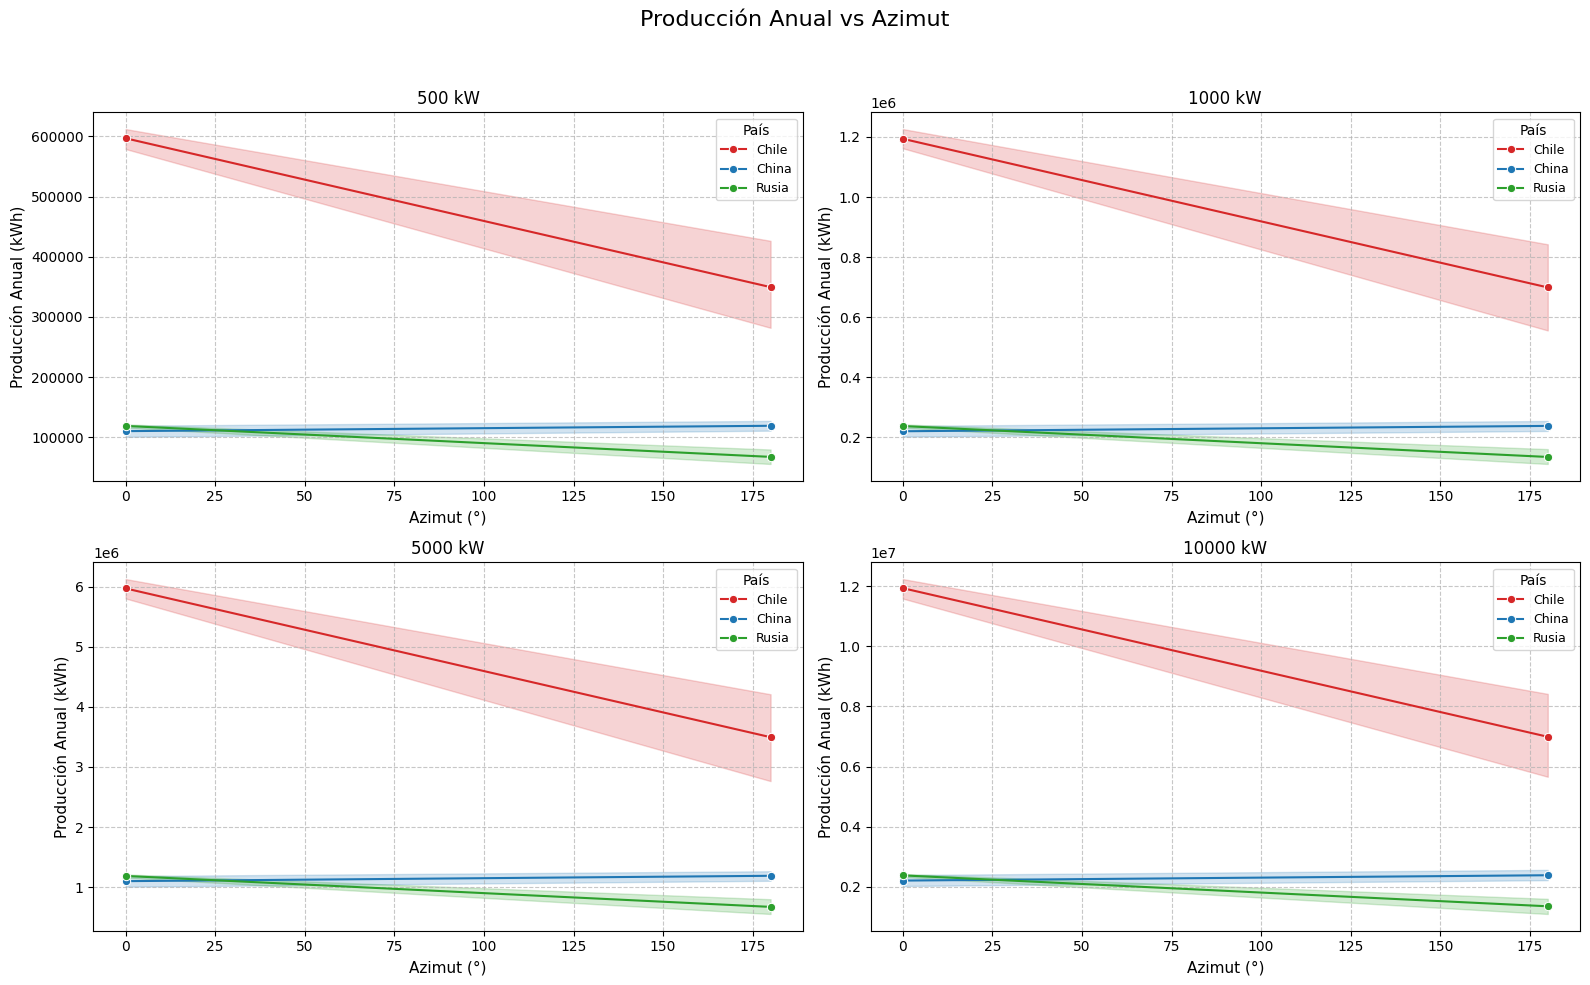

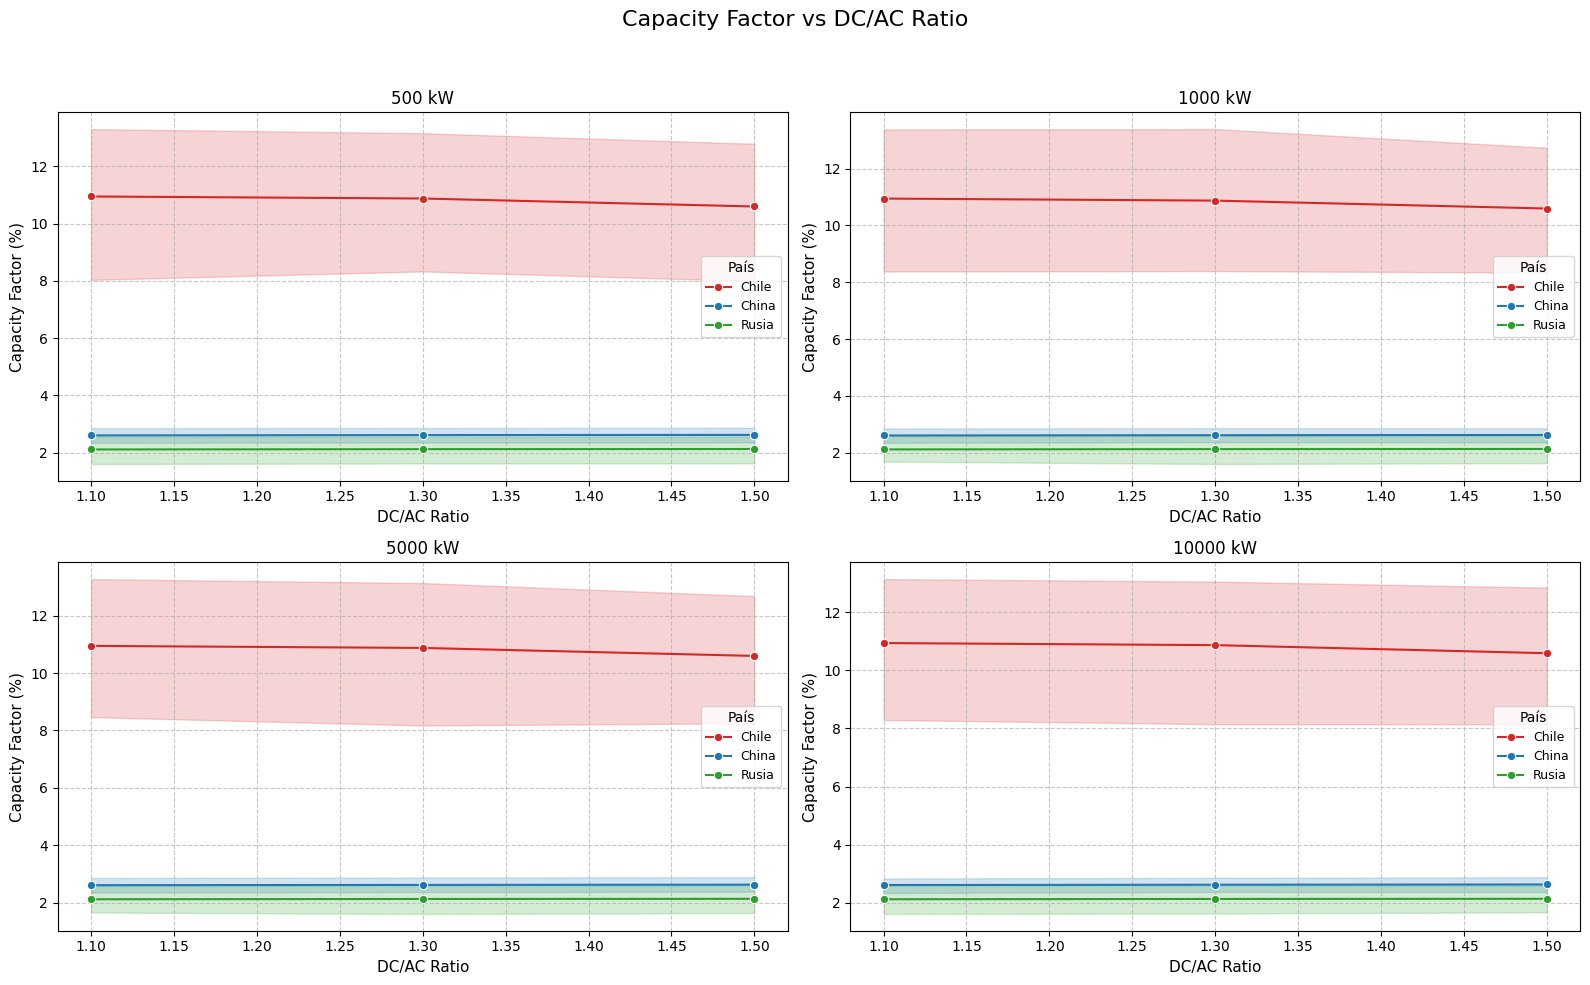

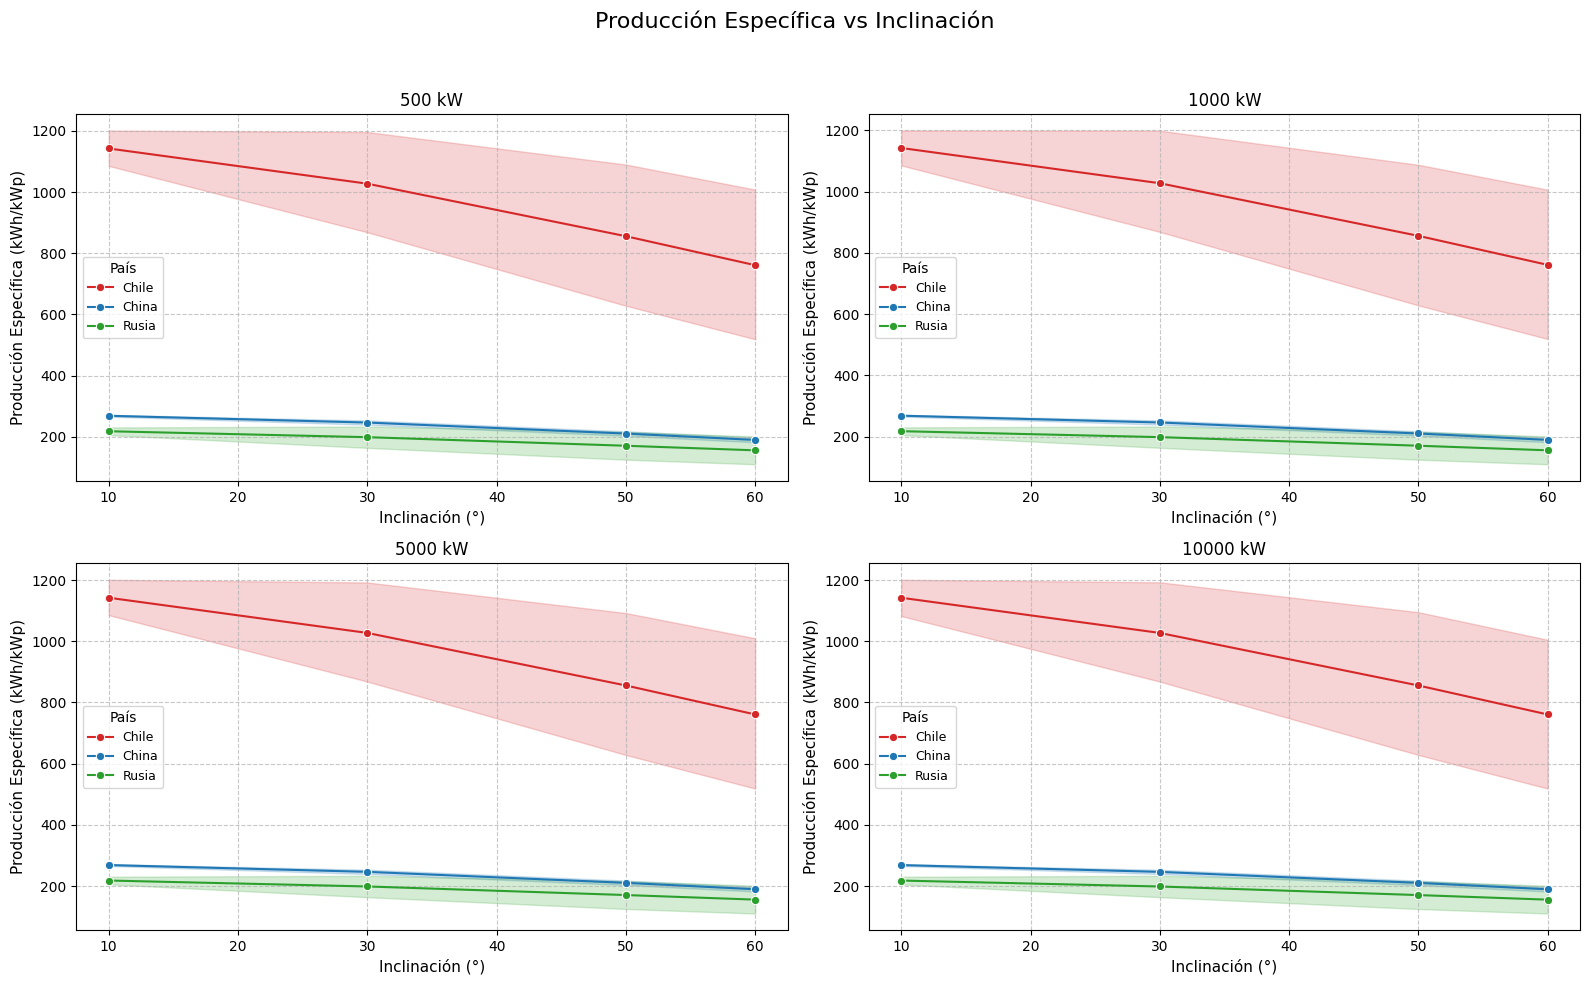

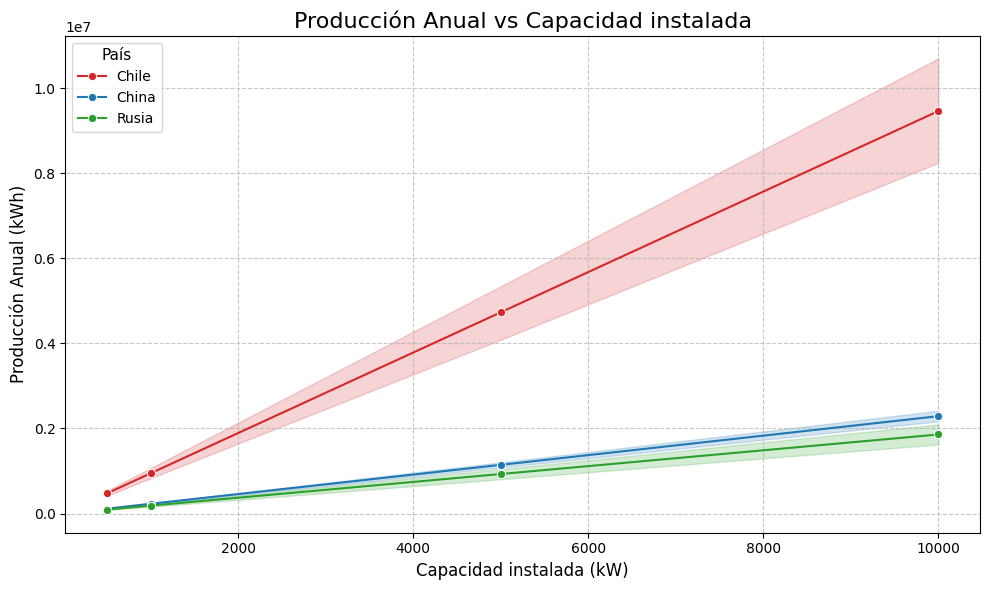

In [1]:
# === Librerías necesarias ===
import PySAM.Pvwattsv8 as pv
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Definir archivos de recurso solar ===
archivos = {
    "Chile": "tmy_-38.320_-71.960_2005_2023_pvwatts_final.csv",
    "China": "tmy_29.652_91.172_2005_2023_pvwatts_final.csv",
    "Rusia": "tmy_59.567_150.800_2005_2023_pvwatts_final.csv"
}

# === 2. Definir configuraciones a simular ===
capacidades_kw = [500, 1000, 5000, 10000]
inclinaciones = [10, 30, 50, 60]
azimuts = [0, 180]
dc_ac_ratios = [1.1, 1.3, 1.5]
combinaciones = list(itertools.product(capacidades_kw, inclinaciones, azimuts, dc_ac_ratios))

# === 3. Simulaciones ===
resultados = []
for pais, archivo in archivos.items():
    for capacidad_kw, tilt, azimuth, dc_ac_ratio in combinaciones:
        modelo = pv.default("PVWattsNone")
        modelo.SolarResource.solar_resource_file = archivo
        modelo.SystemDesign.system_capacity = capacidad_kw
        modelo.SystemDesign.dc_ac_ratio = dc_ac_ratio
        modelo.SystemDesign.array_type = 1
        modelo.SystemDesign.azimuth = azimuth
        modelo.SystemDesign.tilt = tilt
        modelo.SystemDesign.gcr = 0.4
        modelo.SystemDesign.inv_eff = 96
        modelo.SystemDesign.losses = 14.0
        modelo.execute()
        energia_anual = modelo.Outputs.annual_energy
        resultados.append({
            "País": pais,
            "Capacidad (kW)": capacidad_kw,
            "Tilt (°)": tilt,
            "Azimut (°)": azimuth,
            "DC/AC Ratio": dc_ac_ratio,
            "Producción Anual (kWh)": energia_anual
        })

# === 4. Guardar resultados en DataFrame y enriquecer ===
df = pd.DataFrame(resultados)
df = df.sort_values(by=["Capacidad (kW)", "Tilt (°)", "Azimut (°)", "DC/AC Ratio"])
df["Capacity Factor (%)"] = (df["Producción Anual (kWh)"] / (df["Capacidad (kW)"] * 8760)) * 100
df["Producción Específica (kWh/kWp)"] = df["Producción Anual (kWh)"] / df["Capacidad (kW)"]
df.to_csv("resumen_simulaciones_pvwatts_metrico.csv", index=False)
print("✅ Archivo enriquecido guardado como 'resumen_simulaciones_pvwatts_metrico.csv'")

# === 5. Visualización ===
colores = {"Chile": "tab:red", "China": "tab:blue", "Rusia": "tab:green"}
capacidades = df["Capacidad (kW)"].unique()

# Función para organizar subplots
def calcular_filas_columnas(n):
    cols = 2
    rows = (n + cols - 1) // cols
    return rows, cols

# Función para gráficos agrupados
def graficar_agrupado(x_col, y_col, titulo, xlabel, ylabel):
    rows, cols = calcular_filas_columnas(len(capacidades))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*5))
    axes = axes.flatten()
    for idx, capacidad in enumerate(capacidades):
        if idx >= len(axes): break
        ax = axes[idx]
        df_filtro = df[df["Capacidad (kW)"] == capacidad]
        sns.lineplot(data=df_filtro, x=x_col, y=y_col, hue="País", marker="o", palette=colores, ax=ax)
        ax.set_title(f"{int(capacidad)} kW", fontsize=12)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.legend(title="País", fontsize=9, title_fontsize=10)
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Gráficos agrupados
graficar_agrupado("DC/AC Ratio", "Producción Anual (kWh)", "Producción Anual vs DC/AC Ratio", "DC/AC Ratio", "Producción Anual (kWh)")
graficar_agrupado("Tilt (°)", "Producción Anual (kWh)", "Producción Anual vs Inclinación", "Inclinación (°)", "Producción Anual (kWh)")
graficar_agrupado("Azimut (°)", "Producción Anual (kWh)", "Producción Anual vs Azimut", "Azimut (°)", "Producción Anual (kWh)")
graficar_agrupado("DC/AC Ratio", "Capacity Factor (%)", "Capacity Factor vs DC/AC Ratio", "DC/AC Ratio", "Capacity Factor (%)")
graficar_agrupado("Tilt (°)", "Producción Específica (kWh/kWp)", "Producción Específica vs Inclinación", "Inclinación (°)", "Producción Específica (kWh/kWp)")

# Producción Anual vs Capacidad (por país)
plt.figure(figsize=(10,6))
for pais in df["País"].unique():
    df_pais = df[df["País"] == pais]
    sns.lineplot(data=df_pais, x="Capacidad (kW)", y="Producción Anual (kWh)", marker="o", label=pais, color=colores[pais])
plt.title("Producción Anual vs Capacidad instalada", fontsize=16)
plt.xlabel("Capacidad instalada (kW)", fontsize=12)
plt.ylabel("Producción Anual (kWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="País", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()